IMPORTA BIBLIOTECAS

In [2]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

np.random.seed(1)
#tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from datetime import timedelta
import datetime as dt

import seaborn as sn


<AxesSubplot:xlabel='Date'>

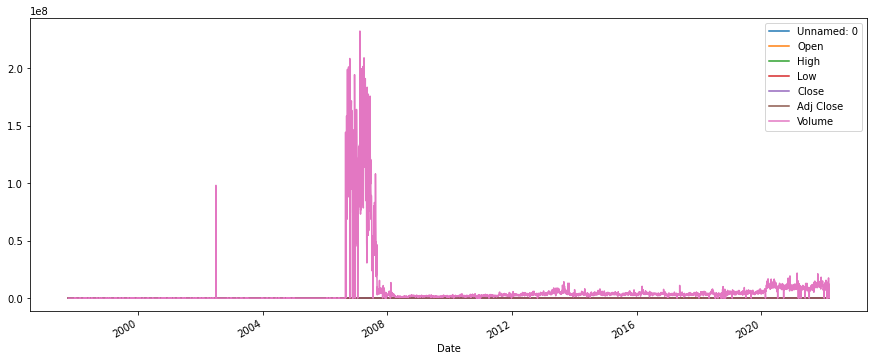

In [10]:
df = pd.read_csv('dataframe.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_values(by='Date')
df.head()
df.plot(figsize=(15, 6))



In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name='Fechar preço'))
fig.update_layout(showlegend=True, title=' Price 1998-2022')
#fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'name': 'Fechar preço',
              'type': 'scatter',
              'x': array([datetime.datetime(1997, 10, 7, 0, 0),
                          datetime.datetime(1997, 10, 8, 0, 0),
                          datetime.datetime(1997, 10, 9, 0, 0), ...,
                          datetime.datetime(2022, 3, 2, 0, 0),
                          datetime.datetime(2022, 3, 3, 0, 0),
                          datetime.datetime(2022, 3, 4, 0, 0)], dtype=object),
              'y': array([ 12481.,  12433.,  12684., ..., 115174., 115166., 114474.])}],
    'layout': {'showlegend': True, 'template': '...', 'title': {'text': ' Price 1998-2022'}}
})

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=scaler.inverse_transform(test_score_df['Close']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

NameError: name 'test_score_df' is not defined

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

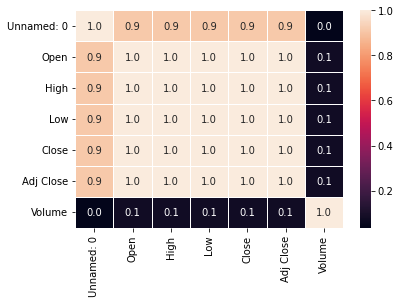

In [19]:
# análise de correlação
correlation = df.corr()
# plot da matriz de correlação

plot = sn.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
plot

# OUTRO MÉTODO DE VISUALIZAÇÃO
corr_df = correlation.corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')